Goal is to predict category of an incident (from temporal and gegraphical information) Type: Classification

# Imports

In [ ]:
!git clone https://github.com/Pink-Raccoon/MLDM_KaggleProjekt.git

fatal: destination path 'MLDM_KaggleProjekt' already exists and is not an empty directory.


In [ ]:
#!pip install geopandas
#!pip install osmnx # https://pygis.io/docs/d_access_osm.html
#!pip install arcgis # https://developers.arcgis.com/python/guide/part5-reverse-geocoding/#the-simple-reverse-geocode-examples

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import folium as fo
import seaborn as sns
# import osmnx
# import osmnx as ox
# import geopandas as gpd

#Loading data from file

In [ ]:
train_data = pd.read_csv("/content/MLDM_KaggleProjekt/sf-crime/train.csv.zip")
train_data.columns

RANDOM_SEED = 0xdeadbeef
train_data.shape
train_data.head(3)

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414


In [ ]:
test_data = pd.read_csv("/content/MLDM_KaggleProjekt/sf-crime/test.csv.zip")
test_data.head(3)

,Id,Dates,DayOfWeek,PdDistrict,Address,X,Y
0,0,2015-05-10 23:59:00,Sunday,BAYVIEW,2000 Block of THOMAS AV,-122.399588,37.735051
1,1,2015-05-10 23:51:00,Sunday,BAYVIEW,3RD ST / REVERE AV,-122.391523,37.732432
2,2,2015-05-10 23:50:00,Sunday,NORTHERN,2000 Block of GOUGH ST,-122.426002,37.792212


# Data-Processing

In [ ]:
#Descript, Resoultion and address are not needed for analysis so they will be dropped
train_data = train_data.drop(columns=['Descript','Resolution', 'Address'])
train_data.dropna(inplace=True)


In [ ]:
test_data = test_data.drop(columns=['Address'])
test_data.dropna(inplace=True)

In [ ]:
train_data.dtypes

Dates          object
Category       object
DayOfWeek      object
PdDistrict     object
X             float64
Y             float64
dtype: object

In [ ]:
#Change datatype of time 
date = pd.to_datetime(train_data["Dates"])
train_data = train_data.drop(columns=['DayOfWeek'])
train_data = train_data.drop(columns=['Dates'])
train_data["Year"] = date.dt.year
train_data["Month"] = date.dt.month
train_data["Day"] = date.dt.day
train_data["Hour"] = date.dt.hour
train_data["DayOfWeek"] = date.dt.weekday #monday = 0, tuesday = 1, ...
train_data.dropna(inplace=True)

In [ ]:
date = pd.to_datetime(test_data['Dates'])
test_data = test_data.drop(columns=['DayOfWeek'])
test_data = test_data.drop(columns=['Dates'])
test_data["Year"] = date.dt.year
test_data["Month"] = date.dt.month
test_data["Day"] = date.dt.day
test_data["Hour"] = date.dt.hour
test_data["DayOfWeek"] = date.dt.weekday  #monday = 0, tuesday = 1, ...
test_data.dropna(inplace=True)

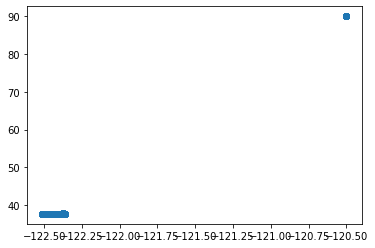

In [ ]:
plt.scatter(train_data.X, train_data.Y)
#coordinate = np.stack((train_data.X, train_data.Y), axis=1)
#plt.scatter(coordinate[:, 0], coordinate[:, 1])

In [ ]:
outliers_train = train_data[train_data["Y"] > 40.] 

In [ ]:
#outliers_train.sort_values(by='Category')

In [ ]:
train_data = train_data[train_data["Y"] < 40.] 
train_data.drop_duplicates()
print(train_data.shape)

(877982, 9)


In [ ]:
#plt.scatter(test_data.X, test_data.Y)

filtered_coordinate = test_data.Y > 40
new_coord = test_data.Y[filtered_coordinate]
print(new_coord.shape)

print(test_data.shape)
test_data = test_data[test_data["Y"] < 40.] 
print(test_data.shape)


(76,)
(884262, 9)
(884186, 9)


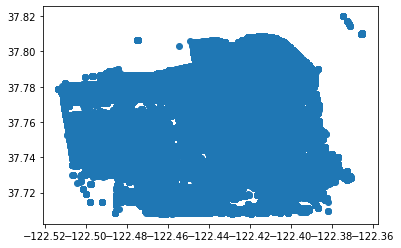

In [ ]:
plt.scatter(train_data.X, train_data.Y)

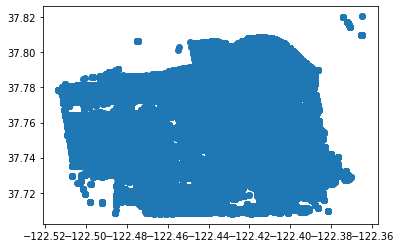

In [ ]:
plt.scatter(test_data.X, test_data.Y)

In [ ]:
#perform data binning on points variable
bin_labels = ['early morning', 'morning', 'noon', 'afternoon', 'evening', 'night']
df_train_bin = train_data
df_train_bin['Hour_bin'] = pd.qcut(df_train_bin['Hour'], q=6)

#view updated DataFrame
df_train_bin['Hour_bin'].value_counts()
df_train_bin = df_train_bin.drop(columns=['Hour'])

#(-0.001, 7.0]	early morning
#(7.0, 11.0]	morning
#(11.0, 14.0]	noon
#(14.0, 17.0]	afternoon
#(17.0, 20.0]	evening  
#(20.0, 23.0]	night

In [ ]:
df_train_bin

,Category,PdDistrict,X,Y,Year,Month,Day,DayOfWeek,Hour_bin
0,WARRANTS,NORTHERN,-122.425892,37.774599,2015,5,13,2,"(20.0, 23.0]"
1,OTHER OFFENSES,NORTHERN,-122.425892,37.774599,2015,5,13,2,"(20.0, 23.0]"
2,OTHER OFFENSES,NORTHERN,-122.424363,37.800414,2015,5,13,2,"(20.0, 23.0]"
3,LARCENY/THEFT,NORTHERN,-122.426995,37.800873,2015,5,13,2,"(20.0, 23.0]"
4,LARCENY/THEFT,PARK,-122.438738,37.771541,2015,5,13,2,"(20.0, 23.0]"
...,...,...,...,...,...,...,...,...,...
878044,ROBBERY,TARAVAL,-122.459033,37.714056,2003,1,6,0,"(-0.001, 7.0]"
878045,LARCENY/THEFT,INGLESIDE,-122.447364,37.731948,2003,1,6,0,"(-0.001, 7.0]"
878046,LARCENY/THEFT,SOUTHERN,-122.403390,37.780266,2003,1,6,0,"(-0.001, 7.0]"
878047,VANDALISM,SOUTHERN,-122.390531,37.780607,2003,1,6,0,"(-0.001, 7.0]"


In [ ]:
df_test_bin = test_data
df_test_bin['Hour_bin'] = pd.qcut(df_test_bin['Hour'], q=6)

#view updated DataFrame
df_test_bin = df_test_bin.drop(columns=['Hour'])
df_test_bin['Hour_bin'].value_counts()

(-0.001, 7.0]    162777
(14.0, 17.0]     151581
(17.0, 20.0]     150819
(7.0, 11.0]      145826
(11.0, 14.0]     141047
(20.0, 23.0]     132136
Name: Hour_bin, dtype: int64

In [ ]:
df_test_bin

,Id,PdDistrict,X,Y,Year,Month,Day,DayOfWeek,Hour_bin
0,0,BAYVIEW,-122.399588,37.735051,2015,5,10,6,"(20.0, 23.0]"
1,1,BAYVIEW,-122.391523,37.732432,2015,5,10,6,"(20.0, 23.0]"
2,2,NORTHERN,-122.426002,37.792212,2015,5,10,6,"(20.0, 23.0]"
3,3,INGLESIDE,-122.437394,37.721412,2015,5,10,6,"(20.0, 23.0]"
4,4,INGLESIDE,-122.437394,37.721412,2015,5,10,6,"(20.0, 23.0]"
...,...,...,...,...,...,...,...,...,...
884257,884257,MISSION,-122.408983,37.751987,2003,1,1,2,"(-0.001, 7.0]"
884258,884258,NORTHERN,-122.425342,37.792681,2003,1,1,2,"(-0.001, 7.0]"
884259,884259,INGLESIDE,-122.445418,37.712075,2003,1,1,2,"(-0.001, 7.0]"
884260,884260,BAYVIEW,-122.387394,37.739479,2003,1,1,2,"(-0.001, 7.0]"


#Plotting the Data

<AxesSubplot: >

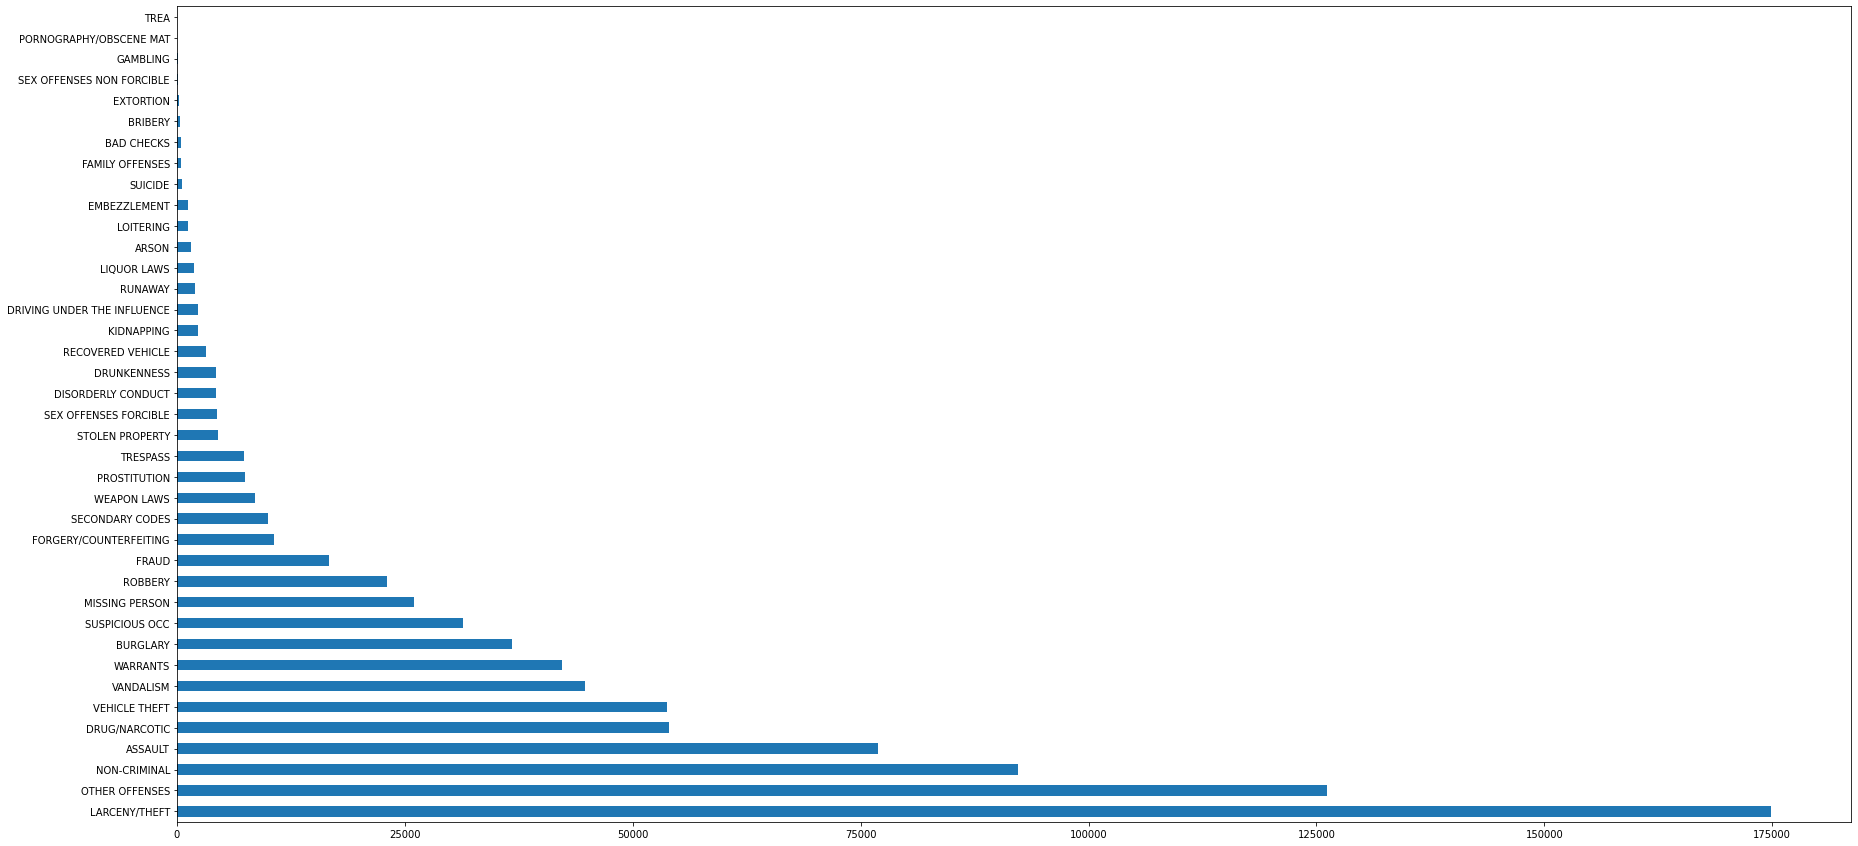

In [ ]:
train_data['Category'].value_counts().plot(kind='barh',figsize=(30, 15))

Text(0.5, 1.0, 'Hour')

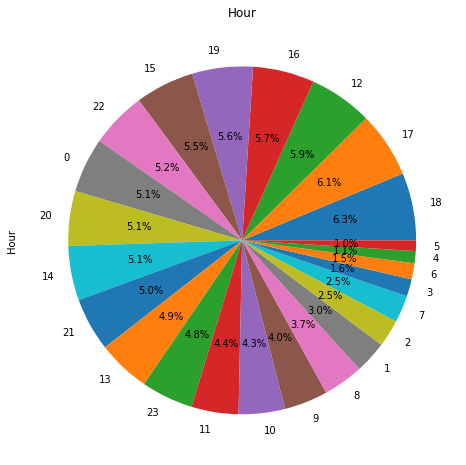

In [ ]:
plt.figure(figsize=(15,8))
train_data['Hour'].value_counts().plot.pie(autopct='%1.1f%%')
plt.title('Hour')

Text(0.5, 1.0, 'DayOfWeekay')

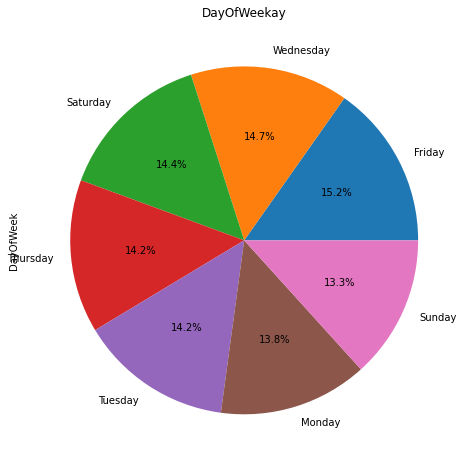

In [ ]:
plt.figure(figsize=(15,8))
train_data['DayOfWeek'].value_counts().plot.pie(autopct='%1.1f%%')
plt.title('DayOfWeekay')

Text(0.5, 1.0, 'Year')

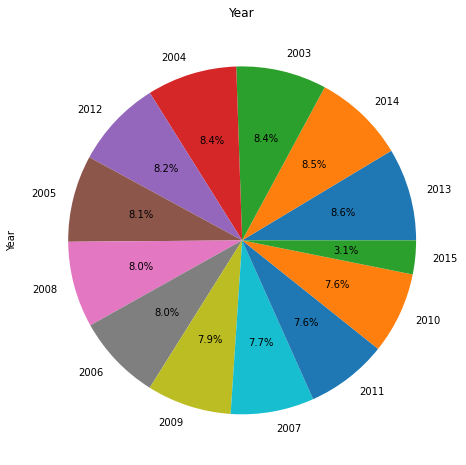

In [ ]:
plt.figure(figsize=(15,8))
train_data['Year'].value_counts().plot.pie(autopct='%1.1f%%')
plt.title('Year')

Text(0.5, 1.0, 'PdDistrict')

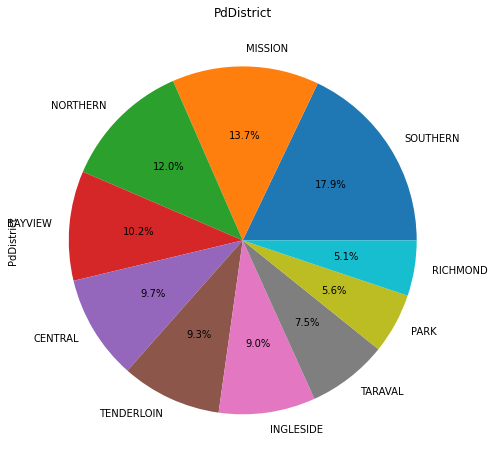

In [ ]:
plt.figure(figsize=(15,8))
train_data['PdDistrict'].value_counts().plot.pie(autopct='%1.1f%%')
plt.title('PdDistrict')

In [ ]:
#train_data.groupby('Category')['Hour'].value_counts()
bins_stuff = [2,3,4,5, 6,7,8,9, 10,11,12,13, 14,15,16,17, 18,19,20,21, 22,23,0,1]
#grps = train_data.groupby(['Category',pd.cut(train_data.Hour,bins_stuff)])
#grps.size().unstack()


<AxesSubplot: xlabel='Hour'>

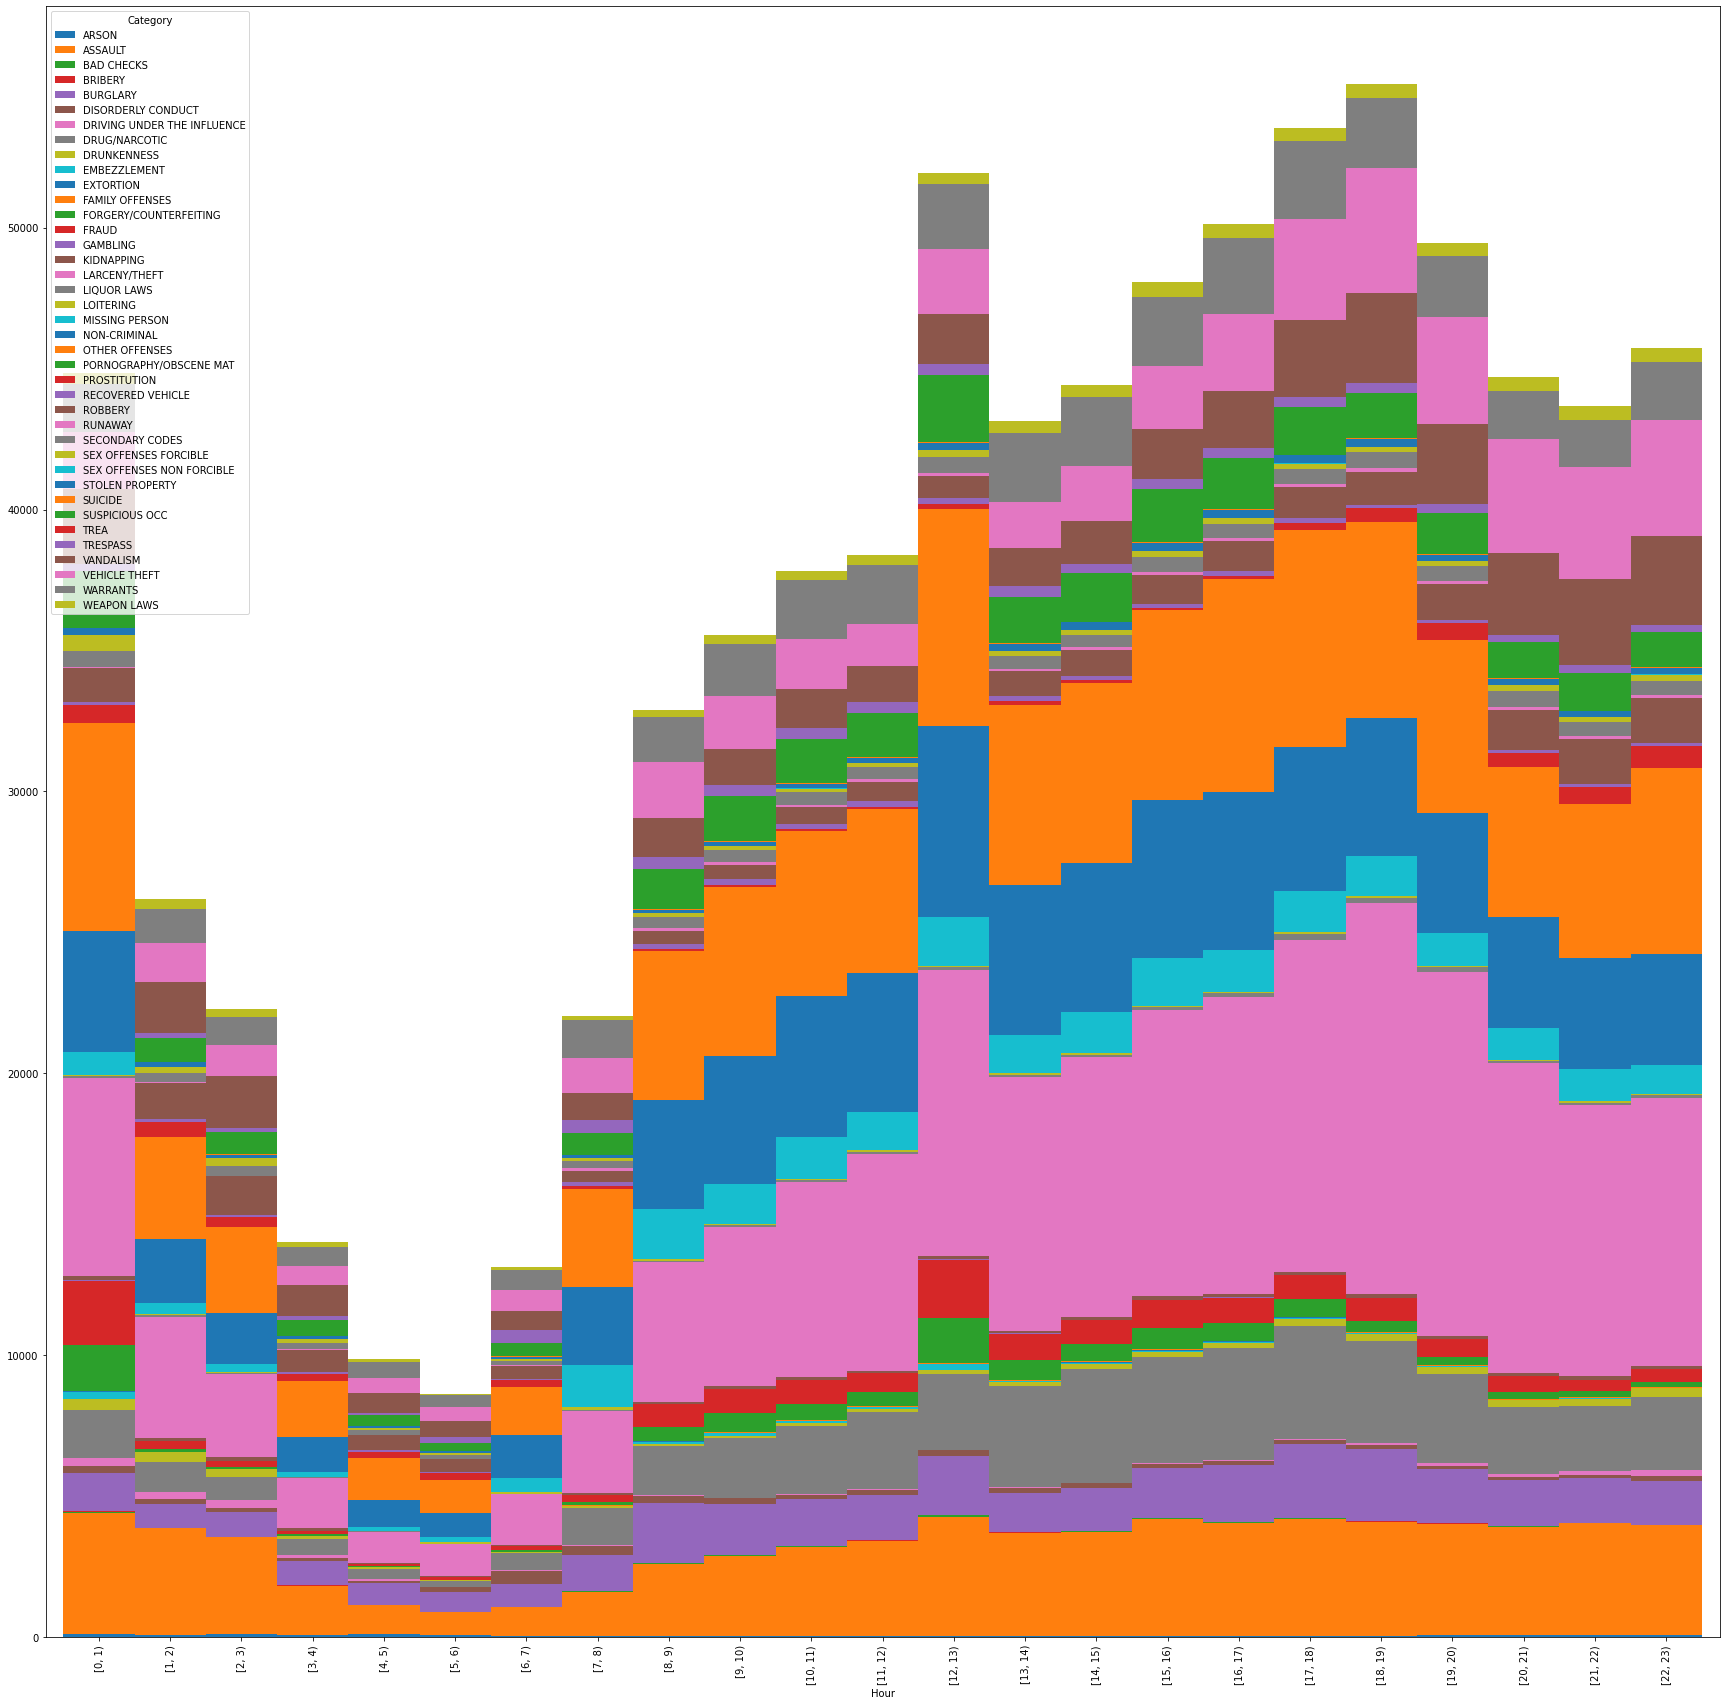

In [ ]:
#train_data['Category'].hist(by=train_data['Hour'],figsize=(200,100))
train_data['Hour'] = pd.cut(train_data.Hour, bins = range(0,24),right=False)
(train_data.groupby('Hour').Category.value_counts().unstack().plot.bar(width=1,stacked=True, figsize=(30,30)))

In [ ]:
bins_stuff = [2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015]
grps = train_data.groupby(['Category',pd.cut(train_data.Year,bins_stuff)])
grps.size().unstack()

Year,"(2003, 2004]","(2004, 2005]","(2005, 2006]","(2006, 2007]","(2007, 2008]","(2008, 2009]","(2009, 2010]","(2010, 2011]","(2011, 2012]","(2012, 2013]","(2013, 2014]","(2014, 2015]"
Category,,,,,,,,,,,,
ARSON,147,106,102,118,134,119,104,98,122,125,115,69
ASSAULT,6466,5776,6364,6105,6327,5976,6128,6117,6199,6280,6254,2325
BAD CHECKS,42,55,47,29,37,26,19,30,24,12,12,4
BRIBERY,18,18,19,23,21,20,30,27,28,32,26,15
BURGLARY,3330,3462,3550,2655,2800,2633,2491,2515,3135,3070,3006,1090
DISORDERLY CONDUCT,417,352,275,323,413,492,430,398,358,211,171,71
DRIVING UNDER THE INFLUENCE,110,98,135,164,206,286,233,233,207,217,184,60
DRUG/NARCOTIC,4873,4379,4700,5219,5866,5951,4489,3374,3408,3319,2767,751
DRUNKENNESS,315,335,356,338,345,410,328,318,315,477,301,109


In [ ]:
bins_stuff = [1,2,3,4,5,6,7]
grps = train_data.groupby(['Category',pd.cut(train_data.Day,bins_stuff)])
grps.size().unstack()

Day,"(1, 2]","(2, 3]","(3, 4]","(4, 5]","(5, 6]","(6, 7]"
Category,,,,,,
ARSON,42,40,63,63,51,57
ASSAULT,2466,2563,2596,2601,2486,2591
BAD CHECKS,15,17,13,12,13,10
BRIBERY,11,3,10,5,10,9
BURGLARY,1094,1110,1153,1132,1239,1178
DISORDERLY CONDUCT,145,139,161,143,138,141
DRIVING UNDER THE INFLUENCE,83,69,93,82,66,65
DRUG/NARCOTIC,1748,1856,2017,1965,1916,1957
DRUNKENNESS,153,174,156,145,150,144


In [ ]:
m = fo.Map(location=[37.773972,-122.446747],zoom_start=13)
fo.Marker(
    location=[37.774599,-122.425892],
    popup="Northern",
    icon=fo.Icon(color="darkgreen"),
).add_to(m)
fo.Marker(
    location=[37.771541,-122.438738],
    popup="Park",
    icon=fo.Icon(color="lightgreen"),
).add_to(m)
fo.Marker(
    location=[37.714056,-122.459033],
    popup="Taraval",
    icon=fo.Icon(color="gray"),
).add_to(m)
fo.Marker(
    location=[37.731948,-122.447364],
    popup="Ingleside",
    icon=fo.Icon(color="pink"),
).add_to(m)
fo.Marker(
    location=[37.780266,-122.403390],
    popup="Southern",
    icon=fo.Icon(color="darkblue"),
).add_to(m)
fo.Marker(
    location=[37.738212,-122.394926],
    popup="Bayview",
    icon=fo.Icon(color="red"),
).add_to(m)
fo.Marker(
    location=[37.78393202772729,-122.412597377187],
    popup="Tenderloin",
    icon=fo.Icon(color="black"),
).add_to(m)
fo.Marker(
    location=[37.7487740050495,-122.42257233421302],
    popup="Mission",
    icon=fo.Icon(color="orange"),
).add_to(m)

fo.Marker(
    location=[37.789434763004	,-122.406958660602],
    popup="Central",
    icon=fo.Icon(color="purple"),
).add_to(m)	
fo.Marker(
    location=[37.7725405391593	,-122.466204667893],
    popup="Richmond",
    icon=fo.Icon(color="lightblue"),
).add_to(m)	

m


In [ ]:
# List key-value pairs for tags
tags = {'building': True}   
#buildings = ox.geometries_from_place("Piedmont, California, USA", tags)
#buildings = ox.geometries_from_point(center_point=point, tags=tags)
#buildings.head()

ele gnis:county_id gnis:created gnis:feature_id  \
element_type osmid                                                         
node         3153686913  NaN            NaN          NaN             NaN   
way          28861558    NaN            NaN          NaN             NaN   
             28861563    NaN            NaN          NaN             NaN   
             28861579    NaN            NaN          NaN             NaN   
             28861587    NaN            NaN          NaN             NaN   

                        gnis:state_id                    name  wikidata  \
element_type osmid                                                        
node         3153686913           NaN                     NaN       NaN   
way          28861558             NaN                     NaN       NaN   
             28861563             NaN                     NaN       NaN   
             28861579             NaN            Morrison Gym       NaN   
             28861587             NaN  Millennium High School  Q6858862   

                                                                  geometry  \
element_type osmid                                                           
node         3153686913                        POINT (-122.21852 37.81518)   
way          28861558    POLYGON ((-122.23486 37.82274, -122.23457 37.8...   
             28861563    POLYGON ((-122.23496 37.82261, -122.23493 37.8...   
             28861579    POLYGON ((-122.23401 37.82203, -122.23400 37.8...   
             28861587    POLYGON ((-122.23392 37.82269, -122.23375 37.8...   

                        addr:city addr:housenumber  ... house religion  \
element_type osmid                                  ...                  
node         3153686913  Piedmont                7  ...   NaN      NaN   
way          28861558    Piedmont              740  ...   NaN      NaN   
             28861563         NaN              NaN  ...   NaN      NaN   
             28861579         NaN              NaN  ...   NaN      NaN   
             28861587    Piedmont              750  ...   NaN      NaN   

                        tourism denomination gnis:county_name  \
element_type osmid                                              
node         3153686913     NaN          NaN              NaN   
way          28861558       NaN          NaN              NaN   
             28861563       NaN          NaN              NaN   
             28861579       NaN          NaN              NaN   
             28861587       NaN          NaN              NaN   

                        gnis:import_uuid gnis:reviewed source ways type  
element_type osmid                                                       
node         3153686913              NaN           NaN    NaN  NaN  NaN  
way          28861558                NaN           NaN    NaN  NaN  NaN  
             28861563                NaN           NaN    NaN  NaN  NaN  
             28861579                NaN           NaN    NaN  NaN  NaN  
             28861587                NaN           NaN    NaN  NaN  NaN  

[5 rows x 41 columns]

In [ ]:
#point = (48.873446, 2.294255)
#dist = 612
#gdf = ox.geometries_from_point(point, tags, dist=dist)
#gdf.head()

addr:postcode amenity operator  \
element_type osmid                                       
node         3980268306           NaN     NaN      NaN   
             3985131776           NaN     NaN      NaN   
way          68991249             NaN     NaN      NaN   
             68991260             NaN     NaN      NaN   
             68991279             NaN     NaN      NaN   

                                                                    source  \
element_type osmid                                                           
node         3980268306                                                NaN   
             3985131776                                                NaN   
way          68991249    cadastre-dgi-fr source : Direction Générale de...   
             68991260    cadastre-dgi-fr source : Direction Générale de...   
             68991279    cadastre-dgi-fr source : Direction Générale de...   

                                                                  geometry  \
element_type osmid                                                           
node         3980268306                           POINT (2.30210 48.87190)   
             3985131776                           POINT (2.30018 48.87706)   
way          68991249    POLYGON ((2.30231 48.87662, 2.30218 48.87657, ...   
             68991260    POLYGON ((2.30261 48.87653, 2.30254 48.87650, ...   
             68991279    POLYGON ((2.30295 48.87652, 2.30291 48.87655, ...   

                         atm             name opening_hours phone wheelchair  \
element_type osmid                                                             
node         3980268306  NaN              ACF           NaN   NaN        NaN   
             3985131776  NaN  Maison nordique           NaN   NaN        NaN   
way          68991249    NaN              NaN           NaN   NaN        NaN   
             68991260    NaN              NaN           NaN   NaN        NaN   
             68991279    NaN              NaN           NaN   NaN        NaN   

                         ... subway tunnel fixme ways type payment:cash  \
element_type osmid       ...                                              
node         3980268306  ...    NaN    NaN   NaN  NaN  NaN          NaN   
             3985131776  ...    NaN    NaN   NaN  NaN  NaN          NaN   
way          68991249    ...    NaN    NaN   NaN  NaN  NaN          NaN   
             68991260    ...    NaN    NaN   NaN  NaN  NaN          NaN   
             68991279    ...    NaN    NaN   NaN  NaN  NaN          NaN   

                        payment:credit_cards internet_access  \
element_type osmid                                             
node         3980268306                  NaN             NaN   
             3985131776                  NaN             NaN   
way          68991249                    NaN             NaN   
             68991260                    NaN             NaN   
             68991279                    NaN             NaN   

                        internet_access:fee reservoir  
element_type osmid                                     
node         3980268306                 NaN       NaN  
             3985131776                 NaN       NaN  
way          68991249                   NaN       NaN  
             68991260                   NaN       NaN  
             68991279                   NaN       NaN  

[5 rows x 150 columns]

#Data splitten

In [ ]:
point = test_data.X[0], test_data.Y[0]
point

(-122.39958770418998, 37.7350510103906)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression 


In [41]:
# Python3 program to Convert a
# list to dictionary
def addKey(i,res_dct,lst):
  res_dct[lst[i]] = i
  return res_dct
def Convert(lst,res_dct):
  for i in range(0, len(lst)):
    res_dct=addKey(i,res_dct,lst)
  return res_dct






In [42]:
res_dct = {}
df = pd.DataFrame(train_data,columns=['Category'])
cat_arr = np.unique(df.to_numpy())
cat_dict = Convert(cat_arr,res_dct)
print(cat_dict)
print(df.to_numpy()[0])

{'ARSON': 0, 'ASSAULT': 1, 'BAD CHECKS': 2, 'BRIBERY': 3, 'BURGLARY': 4, 'DISORDERLY CONDUCT': 5, 'DRIVING UNDER THE INFLUENCE': 6, 'DRUG/NARCOTIC': 7, 'DRUNKENNESS': 8, 'EMBEZZLEMENT': 9, 'EXTORTION': 10, 'FAMILY OFFENSES': 11, 'FORGERY/COUNTERFEITING': 12, 'FRAUD': 13, 'GAMBLING': 14, 'KIDNAPPING': 15, 'LARCENY/THEFT': 16, 'LIQUOR LAWS': 17, 'LOITERING': 18, 'MISSING PERSON': 19, 'NON-CRIMINAL': 20, 'OTHER OFFENSES': 21, 'PORNOGRAPHY/OBSCENE MAT': 22, 'PROSTITUTION': 23, 'RECOVERED VEHICLE': 24, 'ROBBERY': 25, 'RUNAWAY': 26, 'SECONDARY CODES': 27, 'SEX OFFENSES FORCIBLE': 28, 'SEX OFFENSES NON FORCIBLE': 29, 'STOLEN PROPERTY': 30, 'SUICIDE': 31, 'SUSPICIOUS OCC': 32, 'TREA': 33, 'TRESPASS': 34, 'VANDALISM': 35, 'VEHICLE THEFT': 36, 'WARRANTS': 37, 'WEAPON LAWS': 38}
['WARRANTS']


In [43]:
target = df.Category.apply(lambda category: cat_dict[category])

In [45]:
X_train, X_valid, y_train, y_valid= train_test_split(train_data,target,train_size=0.8, random_state=RANDOM_SEED)

In [ ]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_pred = lr_model.predict(X_train)
y_pred_test = lr_model.predict(X_valid)